In [52]:
from mutagene.profiles import Sample
from mutagene.signatures import Identify
import json
import numpy as np
from glob import glob
from subprocess import Popen, PIPE

In [43]:
def get_sub_seq():
    seq = []
    for p5 in "ACGT":
        for p3 in "ACGT":
            for x,y in [('C','A'),('C','G'),('C','T'),('T','A'),('T','C'),('T','G')]:
                seq.append(f"{p5}[{x}>{y}]{p3}")
    return seq

def deconstruct_sigs(profile):
    script1 = """
library(jsonlite)
library(deconstructSigs)
s <- data.frame(t(data.frame(sample=c{})))
colnames(s) <- c{}
w <- whichSignatures(
    tumor.ref = s / sum(s),
    sample.id = 'sample',
    signatures.ref=signatures.cosmic,
    signature.cutoff=0.00)
toJSON(w)
"""
    script2 = script1.format(tuple(profile), tuple(get_sub_seq())).encode("utf-8")

    proc = Popen(["Rscript", "-"], stdin=PIPE, stdout=PIPE, stderr=PIPE)
    out, err = proc.communicate(script2, timeout=10)
    exitcode = proc.returncode
    if exitcode:
        print("Exit code:", exitcode, "Out:", out.decode("utf-8"), "Error:", err.decode("utf-8"), sep="\n\n")
        raise Exception("R error")
    json_string = out.decode("utf-8")
    w = json.loads(json_string)
    # import pprint
    # pprint.pprint(w)
    result = []
    for k, v in w['weights'][0].items():
        if k.startswith('_row'):
            continue
        # if float(v) == 0.0:
        #     continue
        name = k.replace('Signature.', '')
        result.append({
            'name': name,
            'score': v})
    return result

In [23]:
# Find sample files
sample_files = glob('samples/*/data_mutations_mskcc.txt')
list(enumerate(sample_files))

[(0, 'samples/brca_bccrc/data_mutations_mskcc.txt'),
 (1, 'samples/brca_broad/data_mutations_mskcc.txt'),
 (2, 'samples/brca_metabric/data_mutations_mskcc.txt'),
 (3, 'samples/brca_mskcc_2019/data_mutations_mskcc.txt'),
 (4, 'samples/brca_sanger/data_mutations_mskcc.txt'),
 (5, 'samples/breast_msk_2018/data_mutations_mskcc.txt'),
 (6, 'samples/luad_broad/data_mutations_mskcc.txt'),
 (7, 'samples/luad_mskcc_2015/data_mutations_mskcc.txt'),
 (8, 'samples/luad_tcga/data_mutations_mskcc.txt'),
 (9, 'samples/luad_tcga_pan_can_atlas_2018/data_mutations_mskcc.txt'),
 (10, 'samples/luad_tcga_pub/data_mutations_mskcc.txt'),
 (11, 'samples/luad_tsp/data_mutations_mskcc.txt'),
 (12, 'samples/skcm_broad/data_mutations_mskcc.txt'),
 (13, 'samples/skcm_broad_brafresist_2012/data_mutations_mskcc.txt'),
 (14, 'samples/skcm_yale/data_mutations_mskcc.txt')]

In [101]:
# Get samples from multisample file
samples = Sample.multisample(sample_files[4], 'samples/hg19.2bit')

REF allele does not match the genomic sequence in chr12:57643037 G!=C. Multiple errors could mean wrong genome assembly choice
REF allele does not match the genomic sequence in chr12:133244235 G!=C. Multiple errors could mean wrong genome assembly choice
REF allele does not match the genomic sequence in chr12:133245392 G!=C. Multiple errors could mean wrong genome assembly choice


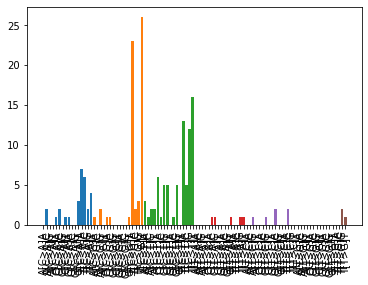

sample	signature	exposure	mutations	exposure_CI_low	exposure_CI_high	mutations_CI_low	mutations_CI_high
VCF	1	0.0666	12	0.0563	0.0769	10	14
VCF	2	0.1389	25	0.1278	0.1500	23	27
VCF	4	0.0437	8	0.0355	0.0520	6	9
VCF	7	0.0523	9	0.0435	0.0611	8	11
VCF	8	0.0103	2	0.0063	0.0143	1	3
VCF	10	0.0668	12	0.0588	0.0749	11	14
VCF	13	0.3868	70	0.3775	0.3961	68	71
VCF	15	0.0171	3	0.0129	0.0213	2	4
VCF	18	0.0245	4	0.0185	0.0304	3	6
VCF	30	0.0116	2	0.0065	0.0168	1	3


[{'name': '1', 'score': 0.1486},
 {'name': '2', 'score': 0.0955},
 {'name': '3', 'score': 0.0358},
 {'name': '4', 'score': 0.1194},
 {'name': '5', 'score': 0},
 {'name': '6', 'score': 0},
 {'name': '7', 'score': 0.0376},
 {'name': '8', 'score': 0},
 {'name': '9', 'score': 0},
 {'name': '10', 'score': 0.0931},
 {'name': '11', 'score': 0.0563},
 {'name': '12', 'score': 0},
 {'name': '13', 'score': 0.4137},
 {'name': '14', 'score': 0},
 {'name': '15', 'score': 0},
 {'name': '16', 'score': 0},
 {'name': '17', 'score': 0},
 {'name': '18', 'score': 0},
 {'name': '19', 'score': 0},
 {'name': '20', 'score': 0},
 {'name': '21', 'score': 0},
 {'name': '22', 'score': 0},
 {'name': '23', 'score': 0},
 {'name': '24', 'score': 0},
 {'name': '25', 'score': 0},
 {'name': '26', 'score': 0},
 {'name': '27', 'score': 0},
 {'name': '28', 'score': 0},
 {'name': '29', 'score': 0},
 {'name': '30', 'score': 0}]

In [105]:
sample_id = 30
samples[sample_id].plot_profile()
Identify(samples[sample_id].profile, 30, bootstrap=True).write_results()
deconstruct_sigs(samples[sample_id].profile)